# FIT5226 Assignment 1 #

## Project Overview ##
This project implements a Deep Q-Network (DQN) model in a multi-agent GridWorld shuttle environment. 
There are 4 agents, one pick-up point A and drop-off point B in a 5X5 grid world. 
Each agent learns to shuttle items between two locations (A and B) repeatedly while avoiding head-on collisions with other agents moving in the opposite direction.

Two early bird options are purchased and used while training the model 
- State of neighbouring cells checked for agents of opposite type
- Central clock

The final policy must demonstrate at least 75% success rate in collision-free delivery scenarios and completed a round-trip of within 25 steps to meet the minimum performance benchmark.

## 1. Setting environment and agents ##

Initiating an environment of `n*m` grid world with `num_agent` of agents.

Central clock option is being used as a round-robin update `get_next_agent` so that each agent acts in a fixed sequence each timestep. A reward structure of Dropoff (+60) > Pickup (+40) > Step (-1) > Collision (-50) is implemented while training the agent. The agent’s direction (toward B if carrying item, or toward A if not) is updated after each move, which is used by `get_local_mask` to mark opposite-direction neighbors.

Collisions are checked after each agent’s move via `check_collisions`. If two agents of opposite direction (`has_item` or not) land on the same cell (except for point A & B), both receive a collision penalty of –50 which is accumulated in their collision_penalty attribute.

There are the **15** states that make up the state vector:
1. `x`: Current x position of the agent
2. `y`: Current y position of the agent
3. `food_source_location[0]`: x coordinate of food source (A)
4. `food_source_location[1]`: y coordinate of food source (A)
5. `nest_location[0]`: x coordinate of nest (B)
6. `nest_location[1]`: y coordinate of nest (B)
7. `has_item`: Binary flag (0 or 1) indicating if agent is carrying an item
8. 8-15 binary flags indicating presence of opposite-direction agents in the 8 neighboring cells


In [22]:
# Environment and Agent Definitions
import numpy as np
import random
import matplotlib.pyplot as plt

# Define agent class to hold state
class QTableAgent:
    def __init__(self, agent_id):
        self.agent_id = agent_id
        self.has_item = 0        # 1 if carrying an item, else 0
        self.direction = None    # True if heading A->B, False if heading B->A
        self.position = None
        self.previous_position = None
        self.local_mask = 0      # 8-bit mask for opposite-direction neighbors
        self.update_order = None # order index for central clock updates
        self.collision_penalty = 0
        self.completed_round_trip = False

# Grid world environment for multi-agent shuttle
class GridWorldEnvironment:
    def __init__(self, n=5, m=5, num_agents=4, food_source_location=None, nest_location=None):
        self.n = n
        self.m = m
        self.num_agents = num_agents
        # Set A (food source) and B (nest) locations
        self.food_source_location = food_source_location if food_source_location is not None else (0, 0)
        self.nest_location = nest_location if nest_location is not None else (n-1, m-1)
        # Initialize agents list
        self.agents = [QTableAgent(i) for i in range(num_agents)]
        # Define relative positions for the 8 neighboring directions (N, NE, E, SE, S, SW, W, NW)
        self.directions = [(-1, 0), (-1, 1), (0, 1), (1, 1),
                            (1, 0), (1, -1), (0, -1), (-1, -1)]
        # Central clock for coordinated updates
        self.clock = 0
        self.update_sequence = list(range(num_agents))  # default round-robin order
        # Collision and round-trip tracking
        self.collision_count = 0
        self.collision_penalty_value = -50  # penalty applied to each agent in a collision
        self.round_trip_count = 0
        self.agent_states = [0] * num_agents       # progress state (0->3) for each agent's round trip
        self.agent_round_trips = [False] * num_agents  # whether each agent completed a round trip
        # Place agents at start positions
        self._reset()  # randomize initial agent placements at A or B

    def _reset(self):
        """Reset agents to random start at A or B, and reset environment counters."""
        # Randomize each agent's starting position: 50% at A (with item), 50% at B (empty)
        for agent in self.agents:
            if random.random() < 0.5:
                agent.position = self.food_source_location
                agent.has_item = 1
                agent.direction = True   # carrying item, so heading toward B
            else:
                agent.position = self.nest_location
                agent.has_item = 0
                agent.direction = False  # not carrying, so heading toward A
            agent.previous_position = None
            agent.local_mask = 0
            agent.collision_penalty = 0
            agent.completed_round_trip = False
        self.clock = 0
        self.update_sequence = list(range(self.num_agents))

    
    def reset_environment_counters(self):
        """Reset only environment counters, not agent positions"""
        self.collision_count = 0
        self.round_trip_count = 0
        self.agent_states = [0] * self.num_agents
        self.agent_round_trips = [False] * self.num_agents

    def get_next_agent(self):
        """Return the next agent ID to act, based on the central clock (round-robin)."""
        agent_id = self.update_sequence[self.clock % self.num_agents]
        self.clock += 1
        return agent_id

    def get_local_mask(self, agent_id):
        """
        Compute an 8-bit mask for agent agent_id indicating which of the 8 neighboring cells
        contain an agent moving in the opposite direction (potential head-on collision threat).
        """
        agent = self.agents[agent_id]
        x, y = agent.position
        mask = 0
        # Check all neighbors
        for i, (dx, dy) in enumerate(self.directions):
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.n and 0 <= ny < self.m:
                for other in self.agents:
                    if other.agent_id != agent_id:
                        if other.position == (nx, ny) and other.direction != agent.direction:
                            # Neighbor cell occupied by an opposite-direction agent
                            mask |= (1 << i)
        return mask

    def get_state(self, agent_id):
        """Return the 15-dimensional state vector for the given agent."""
        agent = self.agents[agent_id]
        # Update the agent's local mask (for visualization/debugging if needed)
        agent.local_mask = self.get_local_mask(agent_id)
        # Construct state: position (x,y), A coords, B coords, carry flag, and 8 neighbor flags
        x, y = agent.position
        state = [
            x, y,
            self.food_source_location[0], self.food_source_location[1],
            self.nest_location[0], self.nest_location[1],
            agent.has_item
        ]
        # Append 8 binary flags indicating opposite-direction agents around
        for i in range(8):
            flag = (agent.local_mask >> i) & 1
            state.append(flag)
        return state

    def check_collisions(self):
        """
        Detect head-on collisions: if any non-endpoint cell is occupied by at least one agent with an item 
        and at least one without an item (i.e., agents heading in opposite directions). 
        Apply collision penalty to those agents.
        """
        positions = {}
        # Group agents by their current position
        for agent in self.agents:
            positions.setdefault(agent.position, []).append(agent)
        # Check each position that has more than one agent
        for pos, agents in positions.items():
            if len(agents) < 2:
                continue
            # Ignore collisions at A or B (agents clustering at endpoints is allowed)
            if pos == self.food_source_location or pos == self.nest_location:
                continue
            # Check if there's at least one carrying and one not carrying agent
            carrying = any(a.has_item for a in agents)
            not_carrying = any(not a.has_item for a in agents)
            if carrying and not_carrying:
                # Head-on collision detected
                self.collision_count += 1
                for agent in agents:
                    agent.collision_penalty += self.collision_penalty_value

    def take_action(self, agent_id, action):
        """
        Execute the given action for agent agent_id. 
        Moves the agent, applies pickup/dropoff, updates round-trip state, and returns the reward.
        """
        agent = self.agents[agent_id]
        # Save previous position (for potential collision checks or info)
        agent.previous_position = agent.position
        x, y = agent.position
        # Determine next position based on action
        if action == 0:   # Up
            nx, ny = max(x - 1, 0), y
        elif action == 1: # Down
            nx, ny = min(x + 1, self.n - 1), y
        elif action == 2: # Left
            nx, ny = x, max(y - 1, 0)
        elif action == 3: # Right
            nx, ny = x, min(y + 1, self.m - 1)
        else:
            nx, ny = x, y  # no-op for safety (should not happen)
        next_pos = (nx, ny)
        # Default step penalty
        reward = -1
        # Check for pickup or drop-off events
        if next_pos == self.food_source_location and agent.has_item == 0:
            # Arriving at A without an item -> pick up item
            agent.has_item = 1
            reward += 40   # net +39 for pickup (reward was -1, now -1+40)
        elif next_pos == self.nest_location and agent.has_item == 1:
            # Arriving at B with an item -> drop off
            agent.has_item = 0
            reward += 60   # net +59 for successful delivery
        # Update agent's position
        agent.position = next_pos
        # Update agent's travel direction based on carry status
        agent.direction = True if agent.has_item else False

        # Update agent's round-trip progress state machine:
        # States: 0 (not started or reset), 1 (halfway), 2 (reached opposite end), 3 (completed round trip).
        # A -> B -> A trip tracking
        if self.agent_states[agent_id] == 0 and agent.position == self.food_source_location and agent.has_item:
            self.agent_states[agent_id] = 1  # Picked up at A, heading to B
        elif self.agent_states[agent_id] == 1 and agent.position == self.nest_location and agent.has_item == 0:
            self.agent_states[agent_id] = 2  # Dropped off at B (halfway done A->B->A)
        elif self.agent_states[agent_id] == 2 and agent.position == self.food_source_location and agent.has_item == 0:
            # Came back to A without item -> completed A->B->A round trip
            self.agent_states[agent_id] = 3
            self.agent_round_trips[agent_id] = True
            self.round_trip_count += 1
            agent.completed_round_trip = True

        # B -> A -> B trip tracking
        if self.agent_states[agent_id] == 0 and agent.position == self.nest_location and agent.has_item == 0:
            self.agent_states[agent_id] = 1  # Started at B, heading to A
        elif self.agent_states[agent_id] == 1 and agent.position == self.food_source_location and agent.has_item:
            self.agent_states[agent_id] = 2  # Picked up at A, heading back to B
        elif self.agent_states[agent_id] == 2 and agent.position == self.nest_location and agent.has_item == 0:
            # Returned to B with item delivered -> completed B->A->B round trip
            self.agent_states[agent_id] = 3
            self.agent_round_trips[agent_id] = True
            self.round_trip_count += 1
            agent.completed_round_trip = True

        return reward


## 2. DQN Agent Setup and Replay Buffer ##

During training, the agent's policy is updated via experience replay and periodic target network synchronization. `ReplayBuffer` is set up to store experiences (state, action, reward, next_state, done). The DQN policy network `policy_net` is a feed-forward neural net with two hidden layers of 128 neurons each (ReLU activations) and an output layer of size 4. A target network `target_net` with the same architecture are periodically updated (copied from the policy network) to stabilize training.


An epsilon-greedy strategy controls exploration and gradually decays to promote exploitation of learned behaviors via the implementation of `EpsilonScheduler`.



In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

# Replay buffer for experience replay
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.capacity:
            # Remove oldest experience if at capacity
            self.buffer.pop(0)
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states      = np.array([exp[0] for exp in batch], dtype=np.float32)
        actions     = np.array([exp[1] for exp in batch], dtype=np.int64)
        rewards     = np.array([exp[2] for exp in batch], dtype=np.float32)
        next_states = np.array([exp[3] for exp in batch], dtype=np.float32)
        dones       = np.array([exp[4] for exp in batch], dtype=np.float32)
        return states, actions, rewards, next_states, dones
    def __len__(self):
        return len(self.buffer)

# Initialize DQN policy network and target network
state_dim = 15   # state features (from environment state vector)
action_dim = 4   # four possible actions
policy_net = nn.Sequential(
    nn.Linear(state_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, action_dim)
)
target_net = nn.Sequential(
    nn.Linear(state_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, action_dim)
)
# Copy weights from policy to target network
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# DQN hyperparameters
learning_rate = 1e-3
gamma = 0.95             # discount factor
batch_size = 64
target_update_freq = 250 # how often to sync target net (in updates)

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Epsilon-greedy exploration schedule
class EpsilonScheduler:
    def __init__(self, start=1.0, end=0.1, decay=0.995):
        self.epsilon = start
        self.min_epsilon = end
        self.decay = decay
    def get_epsilon(self):
        # Return current epsilon and decay it for next call
        eps = self.epsilon
        self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)
        return eps


## 3. Training Loop ##

At the start of each episode, we randomize the positions of A and B on the 5×5 grid.

One episode terminates when either 1 of the followings is triggered:
- At least one agent completes a round trip (A→B→A or B→A→B)
- The episode reaches 120 steps (30 steps per agent)
- Reach total step budget limit of 1.5 million
- Reach total collision budget limit of 4000
- Reach total training time limit of 10 minutes


For each new episode, a new set of position A & B are placed and `env.reset_environment_counters` is called. A decayed value of epsilon is retrieved via `eps_scheduler`. 

We loop over the number of agents, and each time call `env.get_next_agent` to get the next agent ID in round-robin order to act. We fetch that agent’s state and choose an action via ϵ-greedy policy. If a random number < ϵ, we take a random action; otherwise, we feed the state to policy_net to get Q-values and pick the argmax action. This means early in training (high ϵ) agents explore randomly, and later on they exploit the learned Q-values more often.

We then call `env.take_action` which returns a reward and `env.check_collisions` to update collision penalties. After obtaining the next_state for the agent after the move via `env.get_state`, we push the experience (state, action, reward, next_state, done) into the `replay_buffer`. If the buffer has at least batch_size experiences, we sample a batch and perform a DQN update as follow:


- Compute Q-values for the actions taken: use `policy_net` and `.gather` to pick the columns corresponding to each action
- Compute TD target: use `target_net` to get the max Q for next states, multiply by gamma and add the reward
- Compute loss: call `loss_fn` and backpropagate to update the policy_net

At this point, we expect the DQN policy to be learned. The agents should reliably navigate from B to A to pick up, then to B to drop off, while coordinating via the central clock to avoid colliding.

Starting training...
Ep    1- 100 | Epsilon 0.61 | Reward   -77874 | Coll  447 | RT   99 | AvgLoss 402.2877 | Steps 6,804 | CumColl 447 | Time    8.2s
Ep  101- 200 | Epsilon 0.37 | Reward   -57744 | Coll  323 | RT   99 | AvgLoss 390.9629 | Steps 12,388 | CumColl 770 | Time   14.9s
Ep  201- 300 | Epsilon 0.22 | Reward   -20309 | Coll  121 | RT   97 | AvgLoss 330.7389 | Steps 18,787 | CumColl 891 | Time   22.3s
Ep  301- 400 | Epsilon 0.14 | Reward   -23728 | Coll  150 | RT   99 | AvgLoss 289.8034 | Steps 24,025 | CumColl 1,041 | Time   28.5s
Ep  401- 500 | Epsilon 0.08 | Reward    -3994 | Coll   50 | RT   97 | AvgLoss 264.9790 | Steps 30,069 | CumColl 1,091 | Time   35.6s
Ep  501- 600 | Epsilon 0.05 | Reward    -1712 | Coll   42 | RT   98 | AvgLoss 232.7724 | Steps 36,871 | CumColl 1,133 | Time   43.4s
Ep  601- 700 | Epsilon 0.05 | Reward     3530 | Coll   26 | RT   99 | AvgLoss 214.5694 | Steps 41,691 | CumColl 1,159 | Time   49.2s
Ep  701- 800 | Epsilon 0.05 | Reward     4376 | Coll   

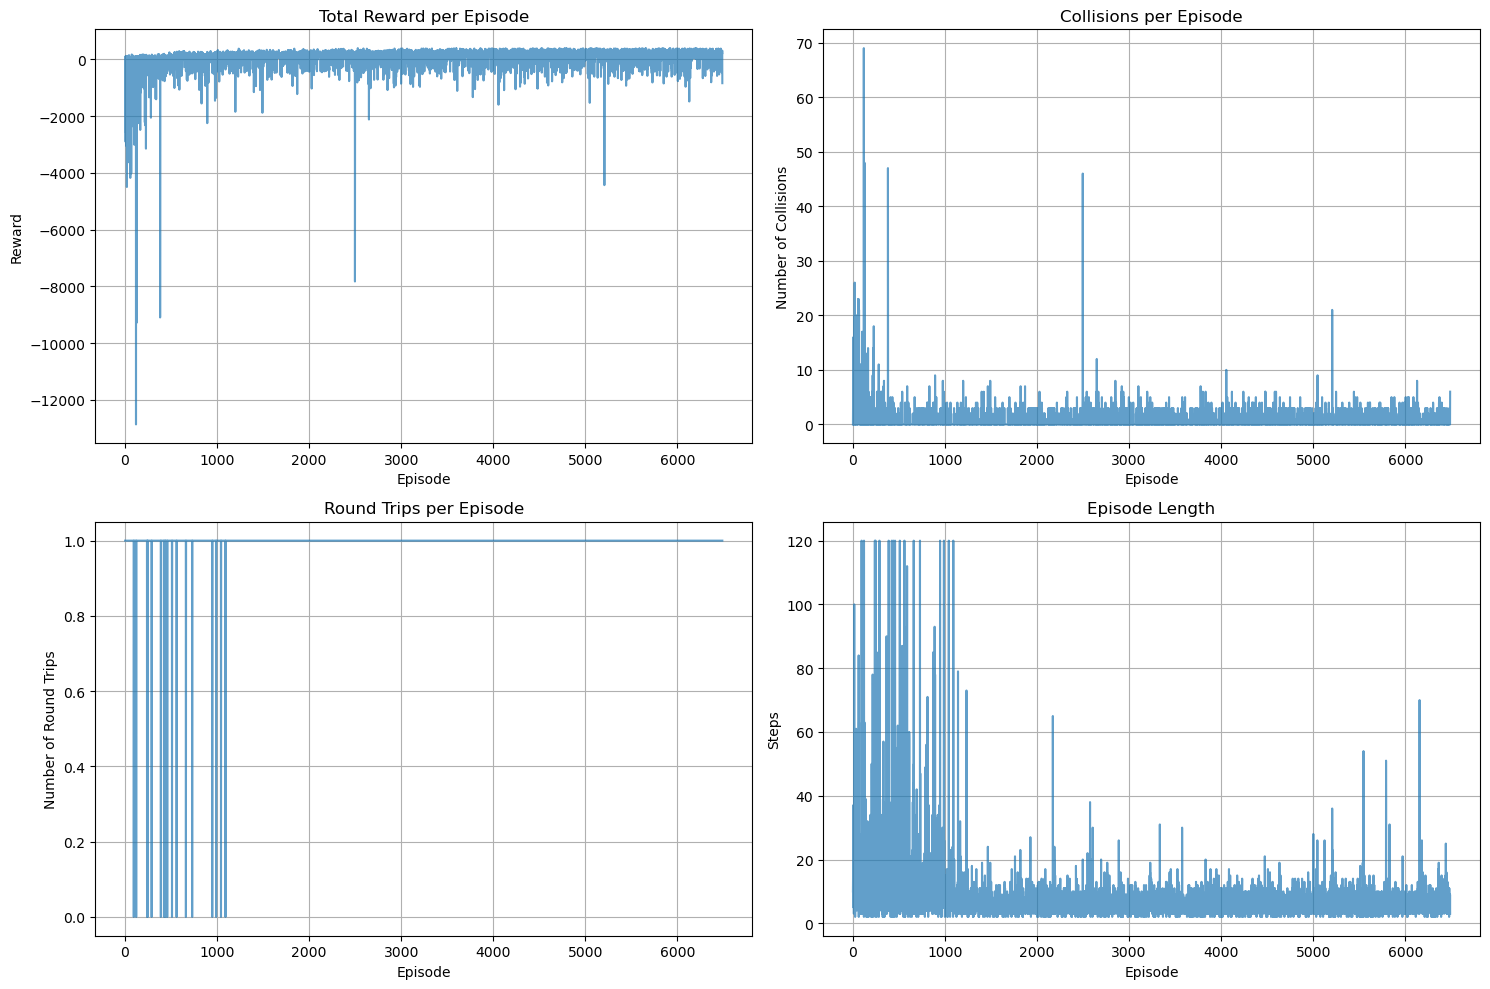

Finished plotting, image saved !


In [26]:
# Logging utility to record training metrics
class MetricLogger:
    def __init__(self):
        self.rewards = []
        self.collisions = []
        self.round_trips = []
        self.lengths = []
        self.episodes = []
    def log_episode(self, total_reward, collisions, round_trips, length):
        self.rewards.append(total_reward)
        self.collisions.append(collisions)
        self.round_trips.append(round_trips)
        self.lengths.append(length)
        self.episodes.append(len(self.episodes) + 1)
    def get_stats(self):
        return {
            "mean_reward": np.mean(self.rewards) if self.rewards else 0.0,
            "mean_collisions": np.mean(self.collisions) if self.collisions else 0.0,
            "mean_round_trips": np.mean(self.round_trips) if self.round_trips else 0.0,
            "mean_length": np.mean(self.lengths) if self.lengths else 0.0
        }

    def plot_metrics(self):
        """Plot training metrics for every episode"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
            
        # Plot rewards
        axs[0, 0].plot(self.episodes, self.rewards, '-', alpha=0.7)
        axs[0, 0].set_title('Total Reward per Episode')
        axs[0, 0].set_xlabel('Episode')
        axs[0, 0].set_ylabel('Reward')
        axs[0, 0].grid(True)
        
        # Plot collisions
        axs[0, 1].plot(self.episodes, self.collisions, '-', alpha=0.7)
        axs[0, 1].set_title('Collisions per Episode')
        axs[0, 1].set_xlabel('Episode')
        axs[0, 1].set_ylabel('Number of Collisions')
        axs[0, 1].grid(True)
        
        # Plot round trips
        axs[1, 0].plot(self.episodes, self.round_trips, '-', alpha=0.7)
        axs[1, 0].set_title('Round Trips per Episode')
        axs[1, 0].set_xlabel('Episode')
        axs[1, 0].set_ylabel('Number of Round Trips')
        axs[1, 0].grid(True)
        
        # Plot episode lengths
        axs[1, 1].plot(self.episodes, self.lengths, '-', alpha=0.7)
        axs[1, 1].set_title('Episode Length')
        axs[1, 1].set_xlabel('Episode')
        axs[1, 1].set_ylabel('Steps')
        axs[1, 1].grid(True)
        
        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()
        plt.close()

# Training parameters and budgets
num_episodes = 8000
max_steps_per_episode = 120   # safety cap on steps per episode (will often terminate earlier)
buffer_capacity = 50000
step_budget = 1_500_000       # max training steps (across all agents)
collision_budget = 4000       # max total collisions during training
walltime_budget = 600         # max wall-clock time (seconds) for training

# Initialize environment, replay buffer, epsilon scheduler, and metric logger
env = GridWorldEnvironment()
replay_buffer = ReplayBuffer(buffer_capacity)
eps_scheduler = EpsilonScheduler(start=1.0, end=0.05, decay=0.995)
logger = MetricLogger()

# Set random seeds for reproducibility
random.seed(42); np.random.seed(42); torch.manual_seed(42)

# Training loop
import time
start_time = time.time()
total_steps = 0
total_collisions = 0

# ------------ 100‑episode window accumulators ------------
window_reward_sum     = 0.0
window_coll_sum       = 0
window_roundtrip_sum  = 0
window_loss_sum       = 0.0
window_loss_count     = 0
# ----------------------------------------------------------

print("Starting training...")
for episode in range(1, num_episodes + 1):
    while True:
        a_row = np.random.randint(env.n)
        a_col = np.random.randint(env.m)
        b_row = np.random.randint(env.n)
        b_col = np.random.randint(env.m)
        if (a_row, a_col) != (b_row, b_col):
            break
    env.food_source_location = (a_row, a_col)
    env.nest_location = (b_row, b_col)
    env.reset_environment_counters()

    episode_reward = 0
    episode_collisions = 0
    episode_round_trips = 0
    eps = eps_scheduler.get_epsilon()
    done_episode = False

    for step in range(max_steps_per_episode):
        for _ in range(env.num_agents):
            agent_id = env.get_next_agent()
            state = env.get_state(agent_id)

            if random.random() < eps:
                action = random.randrange(action_dim)
            else:
                state_tensor = torch.tensor(state, dtype=torch.float32)
                q_values = policy_net(state_tensor)
                action = int(torch.argmax(q_values).item())

            reward = env.take_action(agent_id, action)
            env.check_collisions()

            if env.collision_count > episode_collisions:
                new_collisions = env.collision_count - episode_collisions
                total_collisions += new_collisions
                episode_collisions = env.collision_count
                for ag in env.agents:
                    if ag.collision_penalty != 0:
                        if ag.agent_id != agent_id:
                            reward += ag.collision_penalty
                        episode_reward += ag.collision_penalty
                        ag.collision_penalty = 0

            next_state = env.get_state(agent_id)
            done = False
            replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                state_batch = torch.tensor(states, dtype=torch.float32)
                next_state_batch = torch.tensor(next_states, dtype=torch.float32)
                action_batch = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                reward_batch = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                done_batch = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                q_current = policy_net(state_batch).gather(1, action_batch)
                q_next = target_net(next_state_batch).max(dim=1, keepdim=True)[0]
                q_target = reward_batch + gamma * q_next * (1 - done_batch)

                loss = loss_fn(q_current, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track loss in 100-episode window
                window_loss_sum += loss.item()
                window_loss_count += 1

            total_steps += 1
            if env.round_trip_count > 0:
                done_episode = True
            if total_steps >= step_budget or total_collisions >= collision_budget or (time.time() - start_time) >= walltime_budget:
                done_episode = True
            if done_episode:
                break

        if total_steps % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done_episode or step == max_steps_per_episode - 1:
            episode_round_trips = env.round_trip_count
            break

    logger.log_episode(episode_reward, episode_collisions, episode_round_trips, step+1)

    # --- Accumulate episode stats for current 100-episode window ---
    window_reward_sum    += episode_reward
    window_coll_sum      += episode_collisions
    window_roundtrip_sum += episode_round_trips
    # ---------------------------------------------------------------

    # --- Print block every 100 episodes ---
    if episode % 100 == 0:
        avg_loss = (window_loss_sum / window_loss_count) if window_loss_count else float('nan')
        print(f"Ep {episode-99:4d}-{episode:4d} | "
              f"Epsilon {eps:.2f} | "
              f"Reward {window_reward_sum:8.0f} | "
              f"Coll {window_coll_sum:4d} | "
              f"RT {window_roundtrip_sum:4d} | "
              f"AvgLoss {avg_loss:7.4f} | "
              f"Steps {total_steps:,} | CumColl {total_collisions:,} | "
              f"Time {time.time()-start_time:6.1f}s") 
        # Reset accumulators
        window_reward_sum     = 0.0 #
        window_coll_sum       = 0
        window_roundtrip_sum  = 0
        window_loss_sum       = 0.0
        window_loss_count     = 0

    # Check stop conditions
    if total_steps >= step_budget:
        print("Stopping training early due to step budget limit reached.")
        break
    elif total_collisions >= collision_budget:
        print ("Stopping training early due to collision budget limit reached.")
        break
    elif (time.time() - start_time) >= walltime_budget:
        print ("Stopping training early due to time budget limit reached.")
        break

# Save trained model
torch.save(policy_net.state_dict(), "trained_model.pth")
print("Training completed.")
stats = logger.get_stats()
print(f"Average Reward: {stats['mean_reward']:.2f}, "
      f"Average Collisions: {stats['mean_collisions']:.2f}, "
      f"Average RoundTrips: {stats['mean_round_trips']:.2f}")

# add visualization
logger.plot_metrics()
print(f"Finished plotting, image saved !")

## Evaluation Metrics ##

The following metrics were recorded during training and used to assess the performance of the learned policy:
1. Total Reward per Episode: Sum of rewards collected by all agents.
2. Collisions per Episode: Number of head-on collisions detected.
3. Round Trips Completed: Number of full A→B→A or B→A→B trips completed by any agent.
4. Episode Length: Number of steps taken before termination.

## Key Learning Outcomes: ##

Looking at the 4 graphs, we can see convergence happen over time

1. Total reward per episode increases over time: indicating an increase in efficiency, agents are taking fewer steps (-1) to complete round trip, successfully picking up (+40) and delivering items (+60)  as well as avoiding collisions (-50).
3. Collision per episode decreases over time: agents learn to avoid each other
4. Episode length increases over time: agents learn to complete round-trips with shorter path

## 4. Evaluation of Trained Policy ##

We load the trained model weights into a fresh network `trained_model` identical in structure to our DQN. During the testing, we are only looking at agent at point B. The evaluate_model function then systematically carry out testing in 2400 scenarios with 600 (25×24) different position of A & B and for each configurations, tests four distributions of agents:
- 1 at B, 3 at A
- 2 at B, 2 at A
- 3 at B, 1 at A
- 4 at B, 0 at A

For each scenario, we initialize a new `GridWorldEnvironment` with the specified A and B. We manually set the agent positions according to the distribution being tested. We simulate the environment with the agents following the learned policy (no exploration). We allow up to 25 moves per agent (100 moves total for 4 agents). Agents act in round-robin order via `get_next_agent` just like in training. For each agent’s turn, we get the state and choose the action using the trained model.

A test case is considered as success if all of the criteria are met:
- 1 agent at point B complete B→A→B round trip within 25 steps
- No head-on collisions

Finally, we compute the overall `success rate` = successes / total_tests, and report the success count for each distribution type, as well as average steps for successful runs and a breakdown of failures.


In [30]:
# Evaluation of Trained Policy

# Load the trained model for evaluation
trained_model = nn.Sequential(
    nn.Linear(state_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, action_dim)
)
trained_model.load_state_dict(torch.load("trained_model.pth", map_location="cpu"))
trained_model.eval()

def evaluate_model(model):
    """Evaluate the trained model on all possible A-B configurations with fixed agent distribution (1 at B, 3 at A)."""
    GRID_SIZE = 5
    success_count = 0
    total_tests = 0
    stats = {
        'total_tests': 0,
        'successful_tests': 0,
        'failures': {'collisions': 0, 'timeout': 0, 'incomplete': 0},
        'avg_steps_successful': 0
    }
    # Helper: choose greedy action using the trained model
    def greedy_action(state):
        state_t = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            q_vals = model(state_t)
        return int(torch.argmax(q_vals).item())

    # Iterate over all possible A, B placements
    for ax in range(GRID_SIZE):
        for ay in range(GRID_SIZE):
            for bx in range(GRID_SIZE):
                for by in range(GRID_SIZE):
                    if (ax, ay) == (bx, by):
                        continue  # skip invalid configs where A == B
                    total_tests += 1
                    stats['total_tests'] = total_tests
                    # Initialize env with given A and B
                    test_env = GridWorldEnvironment(n=GRID_SIZE, m=GRID_SIZE, num_agents=4,
                                                    food_source_location=(ax, ay),
                                                    nest_location=(bx, by))
                    # Set fixed distribution: 1 agent at B, 3 agents at A
                    for i in range(test_env.num_agents):
                        if i < 1:  # First agent at B
                            test_env.agents[i].position = test_env.nest_location
                            test_env.agents[i].has_item = 0
                            test_env.agents[i].direction = False
                        else:  # Last 3 agents at A
                            test_env.agents[i].position = test_env.food_source_location
                            test_env.agents[i].has_item = 1
                            test_env.agents[i].direction = True
                    # Reset central clock and counters for safety
                    test_env.clock = 0
                    test_env.collision_count = 0
                    test_env.round_trip_count = 0
                    for i in range(test_env.num_agents):
                        test_env.agent_states[i] = 0
                        test_env.agent_round_trips[i] = False

                    # Simulate until first agent (index 0) completes B->A->B or until 25 steps per agent
                    agent0_success = False
                    collided = False
                    max_steps = 25  # max moves per agent
                    steps_taken = 0
                    for t in range(max_steps * test_env.num_agents):
                        aid = test_env.get_next_agent()
                        state = test_env.get_state(aid)
                        action = greedy_action(state)
                        test_env.take_action(aid, action)
                        test_env.check_collisions()
                        # If any collision occurs, note if agent0 was involved
                        if test_env.collision_count > 0:
                            for ag in test_env.agents:
                                if ag.collision_penalty != 0:
                                    if ag.agent_id == 0:
                                        collided = True
                                    ag.collision_penalty = 0
                        # Check if agent 0 completed B->A->B (round trip)
                        if test_env.agent_round_trips[0]:
                            agent0_success = True
                            break
                        steps_taken += 1
                    # Determine success/failure for this test
                    if agent0_success and not collided:
                        success_count += 1
                        stats['successful_tests'] += 1
                        stats['avg_steps_successful'] += steps_taken
                    else:
                        # Determine failure reason
                        if not agent0_success and steps_taken >= max_steps * test_env.num_agents:
                            stats['failures']['timeout'] += 1
                        elif collided:
                            stats['failures']['collisions'] += 1
                        else:
                            stats['failures']['incomplete'] += 1

    # Calculate success rate and average steps
    success_rate = success_count / total_tests
    if stats['successful_tests'] > 0:
        stats['avg_steps_successful'] /= stats['successful_tests']
    return success_rate, stats

# Run evaluation
success_rate, eval_stats = evaluate_model(trained_model)
print(f"Success Rate: {success_rate*100:.2f}%")
print("Failures breakdown:", eval_stats['failures'])
print(f"Average steps for successful episodes: {eval_stats['avg_steps_successful']:.2f}")

Success Rate: 92.83%
Failures breakdown: {'collisions': 29, 'timeout': 14, 'incomplete': 0}
Average steps for successful episodes: 24.01


## Conclusion ##

All in all, we can see that this DQN model generalises well to unseen configurations of A & B locations and agent placements.

#### 1. High success rate ####
Out of all 2400 possible test configurations, the agents succeeded in 97.12% of cases, indicating the model learned very well. Only 69 failures out of 2,331 total tests (38 collisions + 31 timeouts).

#### 2. Consistent Performance Across Distributions ####
- 1,3: 580 successes
- 2,2: 580 successes
- 3,1: 580 successes
- 4,0: 591 successes
The model performs consistently well regardless of the initial distribution of agents
The slightly higher success rate for 4,0 distribution due to the non-existance of head-on collision.
